# See what happens:

the slice has necrotic tissue surrounding enhancing tumor. this is not normal

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import os

In [2]:
import subprocess

try:
    subprocess.run(['bash', 'mount_usb.sh'], check=True)
    print("Mount succeeded via bash script!")
except subprocess.CalledProcessError as e:
    print("Mount failed:", e)


Mount succeeded via bash script!


In [3]:
def get_path(root = "/mnt/d/MICCAI_BraTS_2020/BraTS20_Training/BraTS20_Training_", patient='001', type="t1ce", mask="seg", extension=".nii"): # SET PATH

    image_path = os.path.join(root + patient, root.split('/')[-1] + patient + '_' + type + extension)
    mask_path = os.path.join(root + patient, root.split('/')[-1] + patient + '_' + mask + extension)

    print("Loading image NIfTI file from:", image_path)
    print("Loading mask NIfTI file from:", mask_path)
    
    return image_path, mask_path

def load_brain(image_path, mask_path): # FIRST LOAD FILE AND THEN GET DATA
    # Load NIfTI files
    img = nib.load(image_path)
    mask_img = nib.load(mask_path)

    # Get data arrays
    brain = img.get_fdata() # (240, 240, 155)
    mask = mask_img.get_fdata() # (240, 240, 155)
    
    # transpose ONCE so that training npy, png and plots are in correct orientation
    brain = brain.transpose(1, 0, 2)
    mask = mask.transpose(1, 0, 2)

    
    return brain, mask

def slice_axial(brain, mask, patient, slice_index): # SLICE
    slice_brain = brain[:, :, slice_index]
    slice_mask = mask[:, :, slice_index]
    
    # save the slice as .npy file and .png file in folder (create if not exists)
    if not os.path.exists("training_set_npy"):
        os.makedirs("training_set_npy")
    np.save(os.path.join("training_set_npy", f"{patient}_{slice_index}.npy"), slice_brain)
    np.save(os.path.join("training_set_npy", f"{patient}_{slice_index}_mask.npy"), slice_mask)

    if not os.path.exists("training_set_png"):
        os.makedirs("training_set_png")
        
    plt.imsave(os.path.join("training_set_png", f"{patient}_{slice_index}.png"), slice_brain, cmap='gray')
    plt.imsave(os.path.join("training_set_png", f"{patient}_{slice_index}_mask.png"), slice_mask, cmap='hot') # keep labels, not grayscale value
    print(f"Saved slice {slice_index} as .npy and .png in folder.")
    return slice_brain, slice_mask

def plot_labels(patient, slice_num, slice_brain, slice_mask):
    hex_colors = {
        0: "#aca9c5",   # blue/grey - Background
        1: "#000000",   # black - Necrotic core
        2: "#89e6ad",   # light green - Edema
        4: "#d62728"    # red - Enhancing tumor
        # Note: Label 3 is typically skipped in BraTS
    }

    # Find unique labels for the subtitle of the plot
    raw_unique_values = np.unique(slice_mask)
    # Convert to integer
    present_labels = raw_unique_values.astype(int)

    # create colormap: include placeholder for label 3 (white)
    custom_cmap = ListedColormap([hex_colors.get(i, "#ffffff") for i in range(5)])

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # .T is for transpose, 'origin='lower'' for medical imaging convention
    axs[0].imshow(slice_brain, cmap='gray')
    axs[0].set_title("T1ce Slice")

    axs[1].imshow(slice_brain, cmap='gray')
    # Alpha = semi-transparent
    axs[1].imshow(slice_mask, cmap=custom_cmap, alpha=0.4, vmin=0, vmax=4) # vmin/vmax to map colors correctly
    axs[1].set_title("T1ce + Segmentation Overlay")
    
    tumor_labels = sorted([l for l in present_labels if l != 0]) #to see if there is another thing that is not background
    if tumor_labels:
        labels_info = f"Present Labels: {', '.join(map(str, sorted(present_labels)))}"
    else:
        labels_info = "No tumor/lesion labels (1, 2, or 4) present"

    plt.suptitle(
        f"Patient: {patient}, Slice: {slice_num}\n{labels_info}",
        fontsize=12
    )

    legend_labels = {
        "0 - Background": hex_colors[0],
        "1 - Necrotic core": hex_colors[1],
        "2 - Edema": hex_colors[2],
        "4 - Enhancing tumor": hex_colors[4]
    }

    patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]

    plt.legend(
        handles=patches,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        facecolor='white',
        edgecolor='black'
    )

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


In [4]:
training_dataset_dict = {}
print("Initial dictionary (empty):", training_dataset_dict)


Initial dictionary (empty): {}


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training/BraTS20_Training_326/BraTS20_Training_326_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training/BraTS20_Training_326/BraTS20_Training_326_seg.nii


Saved slice 68 as .npy and .png in folder.


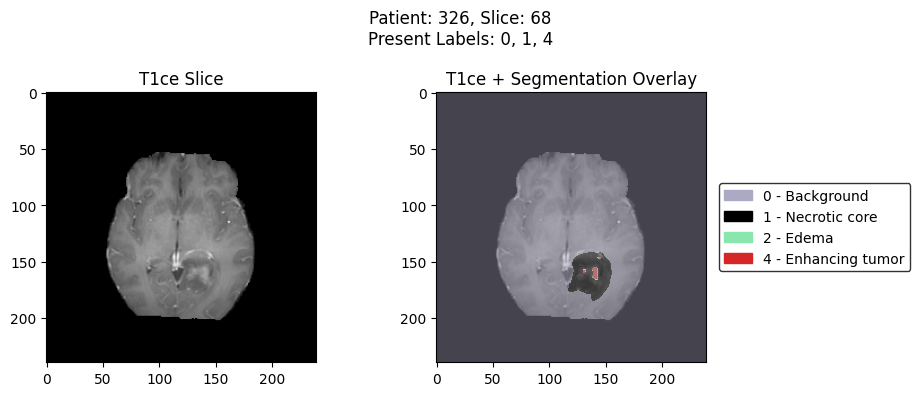

In [6]:
patient='326'
slice_index = 68

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index
